In [1]:
library(ArchR)
library(org.Ss.eg.db)
library(SuscrofaTxdb.11.108.july)
library(stringr)
library(topGO)
library(viridis)


                                                   / |
                                                 /    \
            .                                  /      |.
            \\\                              /        |.
              \\\                          /           `|.
                \\\                      /              |.
                  \                    /                |\
                  \\#####\           /                  ||
                ==###########>      /                   ||
                 \\##==......\    /                     ||
            ______ =       =|__ /__                     ||      \\\
        ,--' ,----`-,__ ___/'  --,-`-===================##========>
       \               '        ##_______ _____ ,--,__,=##,__   ///
        ,    __==    ___,-,__,--'#'  ==='      `-'    | ##,-/
        -,____,---'       \\####\\________________,--\\_##,/
           ___      .______        ______  __    __  .______      
          /   \     |   _ 

In [2]:
calcTopGo <- function(
    allGenes, interestingGenes=NULL, pvals=NULL, geneSel=NULL,
    nodeSize=5, ontology="BP",
    alg="weight01", stat="fisher", topNodes=50
    ){
    # Calculate GO term enrichments using topGO on provided data
    # https://bioconductor.org/packages/release/bioc/vignettes/topGO/inst/doc/topGO.pdf
    ############################################################
    # allGenes: vector of genenames to be used in GO term search. Expects gene 'symbol' 
    # interestingGenes: predefined list of 'instersting' genes. Incompatible with supplying pvalues.
    # geneSel: function for selecting 'interesting' genes. Can only really be a p-value cutoff...
    # pvals: vector of pvalues corresponding to geneList. If not provided, will assign everything to 1
    # nodeSize: will prune terms that have less than nodeSize number of genes
    # ontology: which GO ontology to use (MF, BP, CC)
    # alg: algorithm to be used for testing GO terms (topGO default is 'weight01')
    # stat: test statistic to use for significant GO terms
    # topNodes: how many GO terms to return in result table

    # Prepare geneList as expected for topGO (i.e. value vector with names of genes)
    if(!is.null(interestingGenes)){
        message(sprintf("Running GO enrichments with %s genes in universe of %s...", 
            length(interestingGenes), length(allGenes)))
        geneList <- factor(as.integer(allGenes %in% interestingGenes))
        names(geneList) <- allGenes
        # Create topGOdata object
        GOdata <- suppressMessages(new(
            "topGOdata",
            ontology = ontology,
            allGenes = geneList,
            annot = annFUN.org, mapping = "org.Ss.eg.db", ID = "symbol",
            nodeSize = nodeSize
            ))
    }else{
        geneList <- pvals
        names(geneList) <- allGenes
        message(sprintf("Running GO enrichments with %s genes in universe of %s...", 
            sum(geneSel(geneList)), length(allGenes)))
        GOdata <- suppressMessages(new(
            "topGOdata",
            ontology = ontology,
            allGenes = geneList,
            geneSel = geneSel,
            annot = annFUN.org, mapping = "org.Ss.eg.db", ID = "symbol",
            nodeSize = nodeSize
            ))
    }

    # Test for enrichment using Fisher's Exact Test
    GOresult <- suppressMessages(runTest(GOdata, algorithm=alg, statistic=stat))
    GenTable(GOdata, pvalue=GOresult, topNodes=topNodes, numChar=1000)
}

In [3]:
topGObarPlot <- function(goRes, cmap = NULL, nterms=10, border_color="black", 
    barwidth=0.85, title="", enrichLimits=c(0.0, 5.5), barLimits=NULL){
    # Plot GO results in bar plot form
    goRes$log2FoldEnrichment <- log2(goRes$Significant / goRes$Expected)
    goRes$log2FoldEnrichment <- ifelse(goRes$log2FoldEnrichment > enrichLimits[2], enrichLimits[2], goRes$log2FoldEnrichment)
    goRes$threshPval <- ifelse(goRes$pvalue == "< 1e-30", 1e-30, as.numeric(goRes$pvalue))
    goRes$log10pval <- -log10(goRes$threshPval)
    if(!is.null(barLimits)){
        goRes$log10pval <- ifelse(goRes$log10pval < barLimits[2], goRes$log10pval, barLimits[2])
    }

    # Only plot the top nterms (reverse order to plot most significant at top)
    goRes <- goRes[1:nterms,]
    goRes <- goRes[nrow(goRes):1,]

    if(is.null(cmap)){
        cmap <- cmaps_BOR$comet
    }
    p <- (
        ggplot(goRes, aes(x=Term, y=log10pval, fill=log2FoldEnrichment))
        + geom_bar(stat="identity", width=barwidth, color=border_color)
        + scale_x_discrete(
            limits=goRes$Term, # Required to prevent alphabetical sorting of terms
            labels= function(x) str_wrap(x, width=40) # wrap long GO term labels
            ) 
        + scale_fill_gradientn(colors=cmap, limits=enrichLimits)
        + xlab("")
        + ylab("-log10 pvalue")
        + ggtitle(title)
        + theme_BOR(border=FALSE)
        + theme(panel.grid.major=element_blank(), 
            panel.grid.minor= element_blank(), 
            plot.margin = unit(c(0.25,1,0.25,1), "cm"), 
            #aspect.ratio = 6/nterms, # What is the best aspect ratio for a bar chart?
            axis.text.x = element_text(angle = 90, hjust = 1)) 
        + coord_flip()
    )
    if(!is.null(barLimits)){
        p <- p + scale_y_continuous(limits=barLimits, expand=c(0,0))
    }else{
        p <- p + scale_y_continuous(expand = c(0, 0)) # Make bars start at the axis
    }
    p
}

In [4]:
getFreqs <- function(x){
  # Return a named vector of frequencies of x
  tab <- table(x) %>% as.data.frame.table()
  frqs <- tab$Freq
  names(frqs) <- tab[,1]
  frqs[order(frqs, decreasing=TRUE)]
}

In [5]:
options(repr.plot.width = 18, repr.plot.height = 17, repr.plot.pointsize = 24)

In [6]:
addArchRThreads(1)
addArchRLocking(locking = TRUE)

Setting default number of Parallel threads to 1.

Setting ArchRLocking to TRUE.



In [7]:
load(file = "/home/adufour/work/rds_storage/omics/archr_all_v6.RData")

In [8]:
metadata(archrproj_sub@peakSet)$Peak2GeneLinks@metadata$seATAC <- "/home/adufour/work/archr/StemCells/Peak2GeneLinks/seATAC-Group-KNN.rds"
metadata(archrproj_sub@peakSet)$Peak2GeneLinks@metadata$seRNA <- "/home/adufour/work/archr/StemCells/Peak2GeneLinks/seRNA-Group-KNN.rds"

In [9]:
nclust <- 8

In [10]:
p2gMat <- plotPeak2GeneHeatmap(
  archrproj_sub, 
  corCutOff = 0.5, 
  groupBy="Clusters",
  nPlot = 1000000,
  returnMatrices=TRUE, 
  k=nclust,
  seed=1)

ArchR logging to : ArchRLogs/ArchR-plotPeak2GeneHeatmap-2480efa4a746c-Date-2023-08-11_Time-09-48-36.log
If there is an issue, please report to github with logFile!

2023-08-11 09:48:40 : Determining KNN Groups!, 0.068 mins elapsed.

2023-08-11 09:48:42 : Ordering Peak2Gene Links!, 0.113 mins elapsed.



In [11]:
p2gplot <- plotPeak2GeneHeatmap(
  archrproj_sub, 
  corCutOff = 0.5, 
  groupBy="Clusters",
  nPlot = 1000000,
  returnMatrices=FALSE, 
  k=nclust,
  seed=1)

ArchR logging to : ArchRLogs/ArchR-plotPeak2GeneHeatmap-2480ef5a0ab374-Date-2023-08-11_Time-09-48-48.log
If there is an issue, please report to github with logFile!

2023-08-11 09:48:52 : Determining KNN Groups!, 0.067 mins elapsed.

2023-08-11 09:48:55 : Ordering Peak2Gene Links!, 0.109 mins elapsed.

2023-08-11 09:49:00 : Constructing ATAC Heatmap!, 0.203 mins elapsed.

Warning message:
“le package ‘circlize’ a été compilé avec la version R 4.2.3”
Adding Annotations..

Preparing Main Heatmap..

2023-08-11 09:49:02 : Constructing RNA Heatmap!, 0.226 mins elapsed.

Adding Annotations..

Preparing Main Heatmap..

ArchR logging successful to : ArchRLogs/ArchR-plotPeak2GeneHeatmap-2480ef5a0ab374-Date-2023-08-11_Time-09-48-48.log



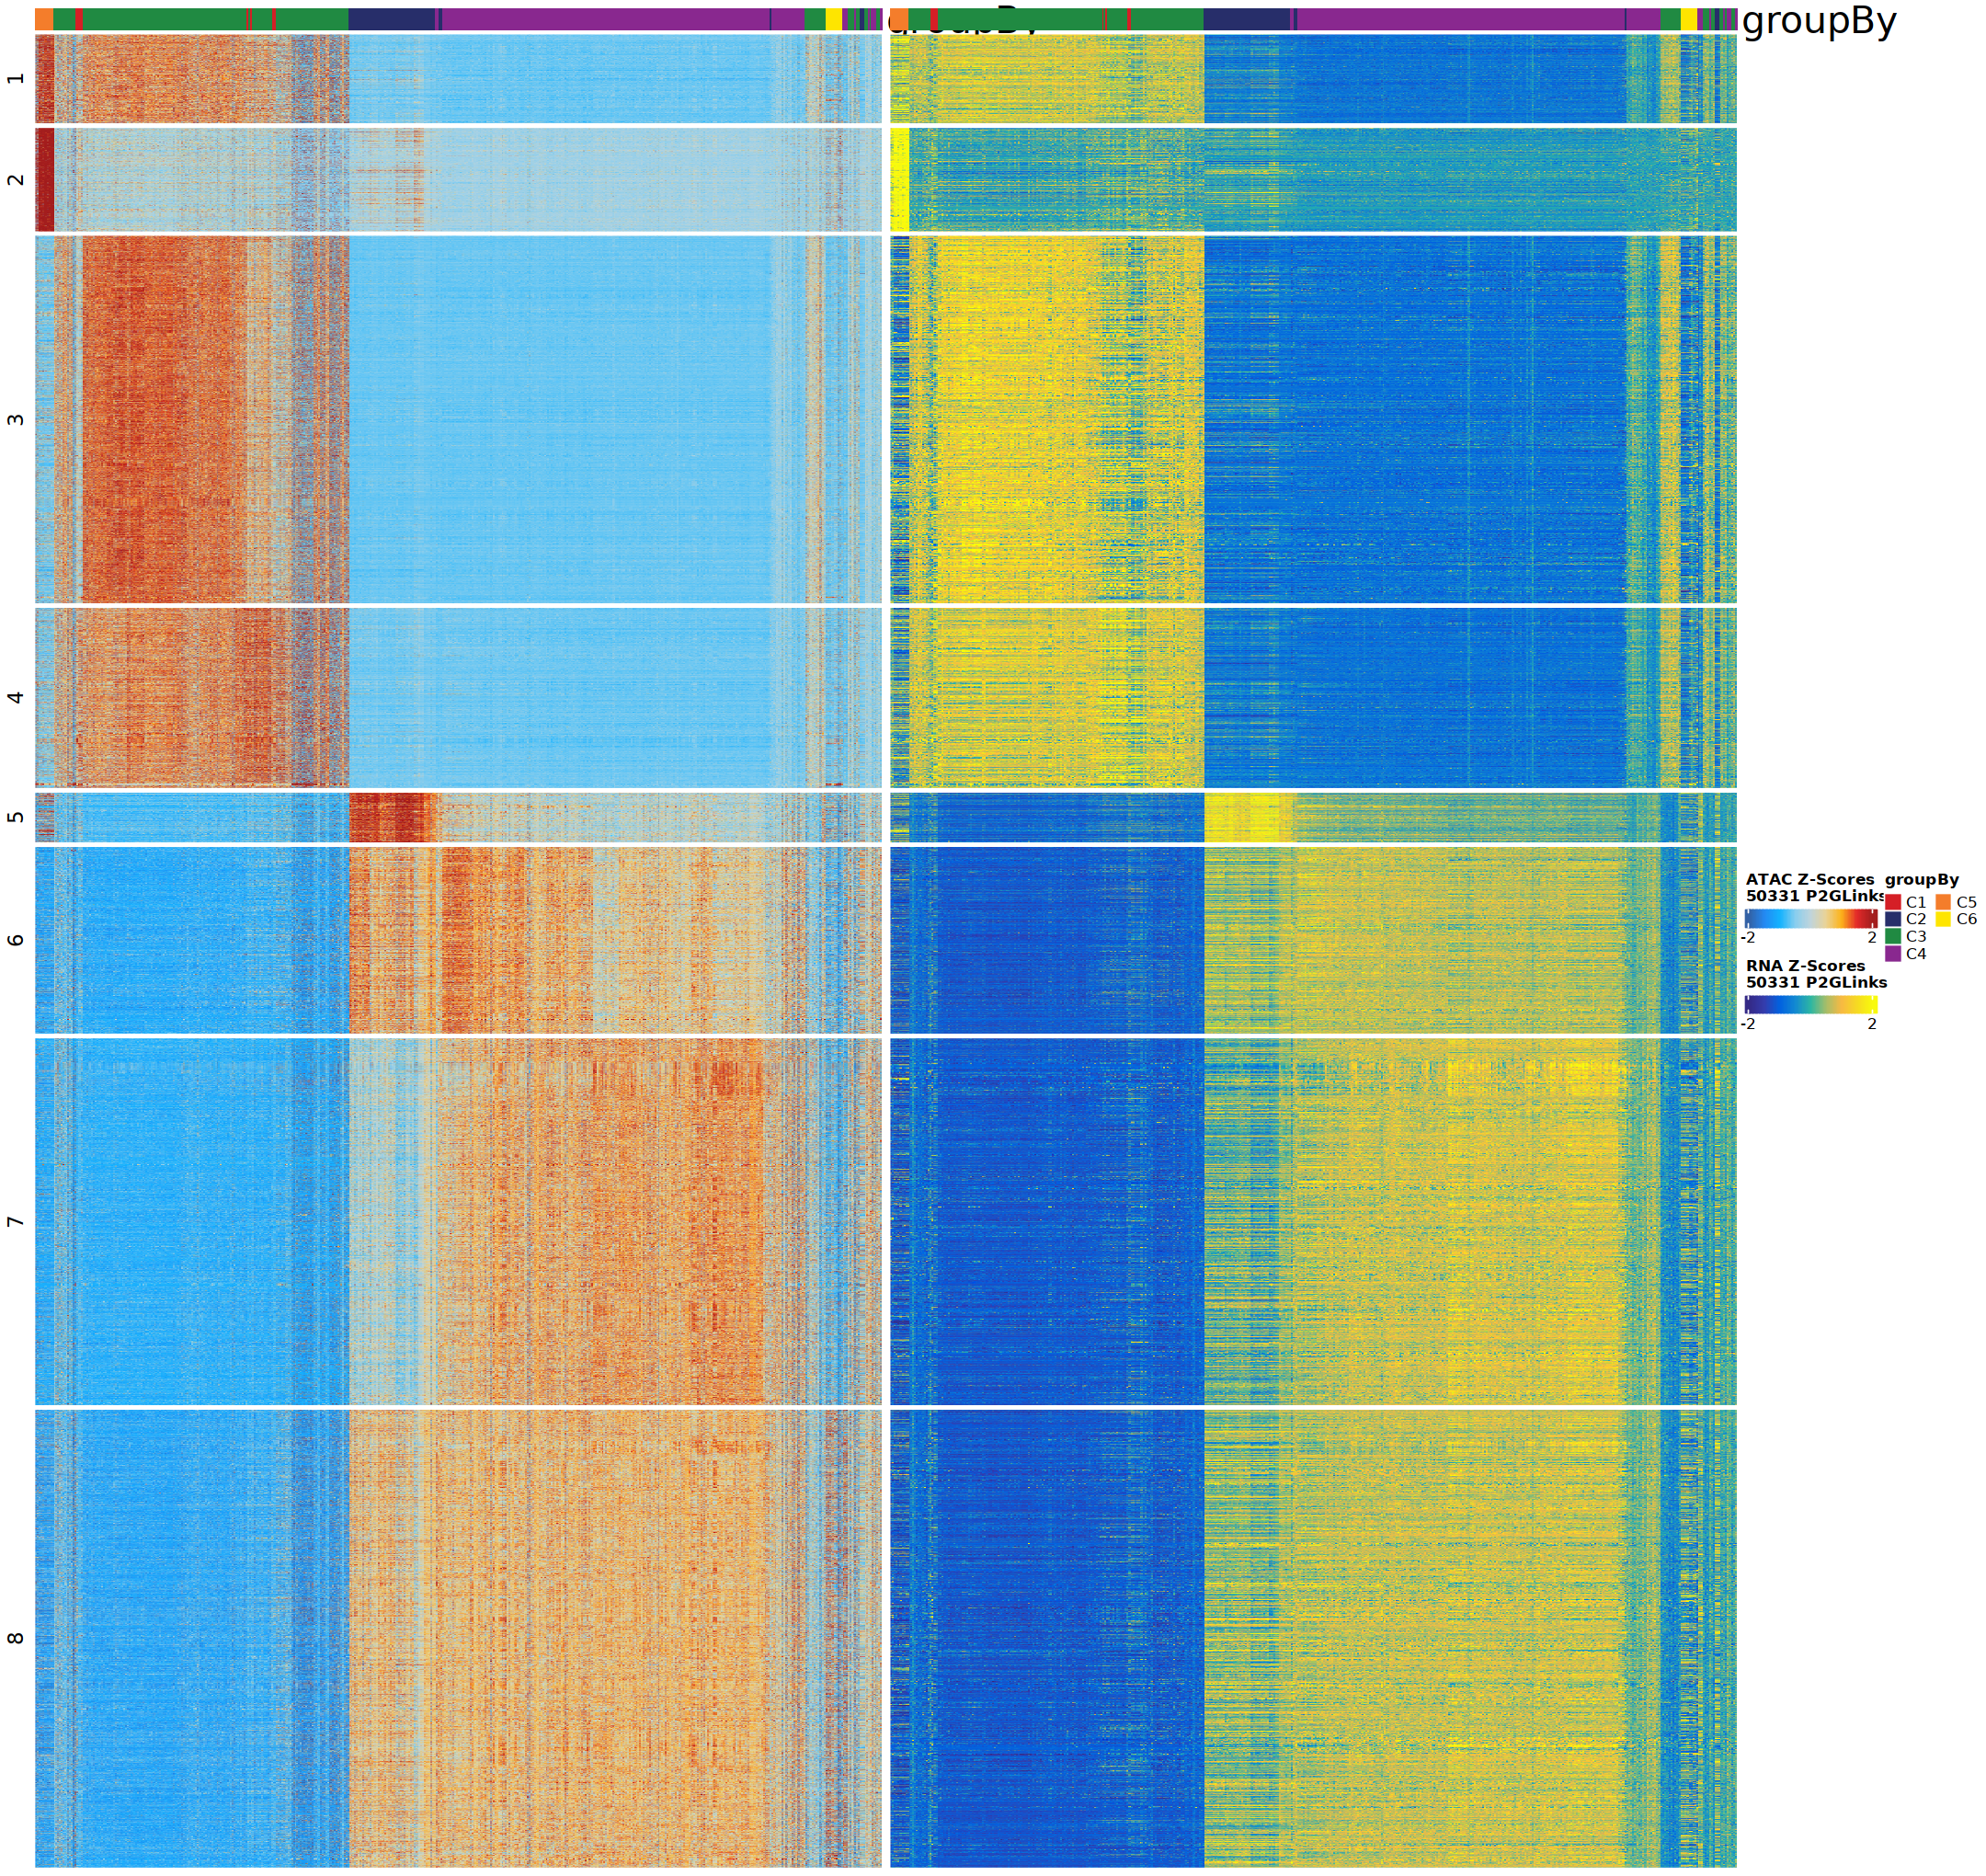

In [12]:
p2gplot

In [13]:
plotDir <- "/home/adufour/work/notebook/plots/omics/P2G"

In [14]:
kclust_df <- data.frame(
  kclust=p2gMat$ATAC$kmeansId,
  peakName=p2gMat$Peak2GeneLinks$peak,
  gene=p2gMat$Peak2GeneLinks$gene
)

In [15]:
kclust_df$peakName <- sapply(kclust_df$peakName, function(x) strsplit(x, ":|-")[[1]] %>% paste(.,collapse="_"))

In [16]:
kclust <- unique(kclust_df$kclust) %>% sort()
all_genes <- kclust_df$gene %>% unique() %>% sort()

In [17]:
# Save table of top linked genes per kclust
nGOgenes <- 1000
topKclustGenes <- lapply(kclust, function(k){
  kclust_df[kclust_df$kclust == k,]$gene %>% getFreqs() %>% head(nGOgenes) %>% names()
  }) %>% do.call(cbind,.)
outfile <- paste0(plotDir, sprintf("/topN_genes_embryo_kclust_k%s.tsv", nclust))
write.table(topKclustGenes, file=outfile, quote=FALSE, sep='\t', row.names = FALSE, col.names=TRUE)

Warning message in cbind(...):
“number of rows of result is not a multiple of vector length (arg 2)”


In [18]:
GOresults <- lapply(kclust, function(k){
  message(sprintf("Running GO enrichments on k cluster %s...", k))
  clust_genes <- topKclustGenes[,k]
  upGO <- rbind(
    calcTopGo(all_genes, interestingGenes=clust_genes, nodeSize=5, ontology="BP") 
    #calcTopGo(all_genes, interestingGenes=clust_genes, nodeSize=5, ontology="MF")
    #calcTopGo(all_genes, interestingGenes=upGenes, nodeSize=5, ontology="CC")
    )
  upGO[order(as.numeric(upGO$pvalue), decreasing=FALSE),]
  })

Running GO enrichments on k cluster 1...

Running GO enrichments with 1000 genes in universe of 8079...

Running GO enrichments on k cluster 2...

Running GO enrichments with 1000 genes in universe of 8079...

Running GO enrichments on k cluster 3...

Running GO enrichments with 1000 genes in universe of 8079...

Running GO enrichments on k cluster 4...

Running GO enrichments with 1000 genes in universe of 8079...

Running GO enrichments on k cluster 5...

Running GO enrichments with 1000 genes in universe of 8079...

Running GO enrichments on k cluster 6...

Running GO enrichments with 1000 genes in universe of 8079...

Running GO enrichments on k cluster 7...

Running GO enrichments with 1000 genes in universe of 8079...

Running GO enrichments on k cluster 8...

Running GO enrichments with 1000 genes in universe of 8079...



In [19]:
names(GOresults) <- paste0("cluster_", kclust)

In [25]:
colors_dutch <- c(
  '#FFC312','#C4E538','#12CBC4','#FDA7DF','#ED4C67',
  '#F79F1F','#A3CB38','#1289A7')

In [26]:
names(colors_dutch) <- c("C1", "C2", "C3", "C4", "C5", "C6", "C7", "C8")

In [30]:
# Plots of GO term enrichments:
for(name in names(GOresults)){
    goRes <- GOresults[[name]]
    if(nrow(goRes)>1){
      svglite(paste0("/home/adufour/work/notebook/plots/omics/P2G/p2g_GO_knn", name, "_embryo.svg"), width = 17, height = 20)
      print(topGObarPlot(goRes, cmap = viridis(256, option = "D"), 
        nterms=3, border_color="black", 
        barwidth=0.85, title=name, barLimits=c(0, 15)))
      dev.off()
    }
}

png 
  2

In [23]:
theme_BOR <- function(base_size=14, base_family="Helvetica", border = TRUE) {
  library(grid)
  library(ggthemes)
  # Should plots have a bounding border?
  if(border){
    panel.border <- element_rect(fill = NA, color = "black", size = 0.7)
    axis.line <- element_blank()
  }else{
    panel.border <- element_blank()
    axis.line <- element_line(color = "black", size = 0.5)
  }
  
  (theme_foundation(base_size=base_size, base_family=base_family)
    + theme(plot.title = element_text(size = rel(1.2), hjust = 0.5),
            text = element_text(),
            panel.background = element_rect(colour = NA),
            plot.background = element_rect(colour = NA),
            panel.border = panel.border,
            axis.title = element_text(size = rel(1)),
            axis.title.y = element_text(angle=90,vjust =2),
            axis.title.x = element_text(vjust = -0.2),
            axis.text = element_text(), 
            axis.line = axis.line,
            axis.ticks = element_line(),
            panel.grid.major = element_blank(),
            panel.grid.minor = element_blank(),
            legend.key = element_rect(colour = NA),
            legend.position = "right",
            legend.direction = "vertical",
            legend.key.size= unit(0.5, "cm"),
            legend.spacing = unit(0, "cm"),
            legend.title = element_text(),
            plot.margin=unit(c(10,5,5,5),"mm"),
            strip.background=element_rect(colour="#f0f0f0",fill="#f0f0f0"),
            strip.text = element_text()
    ))
  
}